In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
from scipy import optimize

%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE/1.5, direction='out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE/1.5, direction='out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE/2)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
# Retreive all the data from the meta-data_epoch file
meta_data = ascii.read('../dataredred/J0600_meta-data_epoch.txt')

epoch_arr = np.array(meta_data["EPOCH"])

filters = np.array(meta_data["FILTER"]) # Filters of all the .fits images
airmass_arr = np.array(meta_data["AIRMASS"]) # Airmasses for all the .fits images

fits_name_arr = np.array(meta_data["IMAGE"]) # Name of the original .fits file
files_arr = np.array(meta_data["FILENAME"]) # Name of the data reduced files

N_files = len(epoch_arr) #nr of files
N_stars = len(ascii.read(files_arr[0])["STARNR"])-1 #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 1645
Number of stars = 30


In [3]:
# Make a mask for all the filters:
filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in filt:
        filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)
print (NimgINf)

fmask = {}
for f in filt:
    fmask[f] = filters == f

    
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars+1))
fluxerr_tmp = np.zeros((N_files,N_stars+1))

for i in range(N_files):
    file = files_arr[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = np.array(filecontent["FLUX"])
    fluxerr_tmp[i] = np.array(filecontent["FLUXERR"])

print (np.shape(flux_tmp))
print (np.shape(fluxerr_tmp))


# Make a dictionary where flux[filter] gives an array with all the data for that filter
# And do the same for epoch, airmass, fits_name and files
J0600_flux = {}
J0600_fluxerr = {}
flux = {}
fluxerr = {}

epoch = {}
airmass = {}
fits_name = {}
files = {}

for f in filt:
    J0600_flux[f] = flux_tmp[fmask[f]][:,0]
    J0600_fluxerr[f] = fluxerr_tmp[fmask[f]][:,0]
    flux[f] = flux_tmp[fmask[f]][:,1:]
    fluxerr[f] = fluxerr_tmp[fmask[f]][:,1:]
    
    epoch[f] = epoch_arr[fmask[f]]
    airmass[f] = airmass_arr[fmask[f]]
    fits_name[f] = fits_name_arr[fmask[f]]
    files[f] = files_arr[fmask[f]]


['gp', 'ip', 'rp']
{'gp': 743, 'ip': 601, 'rp': 301}
(1645, 31)
(1645, 31)


In [4]:
# Retreive the data from the meta-data_stars file
meta_data_stars = ascii.read("../dataredred/J0600_meta-data_stars.txt")

J0600_coords = [meta_data_stars[filt[0]+'_RA'][0],meta_data_stars[filt[0]+'_Dec'][0]]

original_starnr = {}
star_coords = {}
for f in filt:
    original_starnr[f] = np.array(meta_data_stars[f+"_star"][1:])
    
    RA = meta_data_stars[f+'_RA'][1:]
    Dec = meta_data_stars[f+'_Dec'][1:]
    star_coords[f] = np.array([RA,Dec]).transpose()

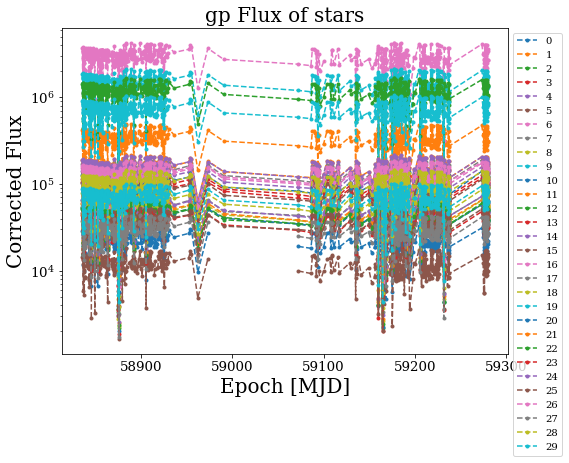

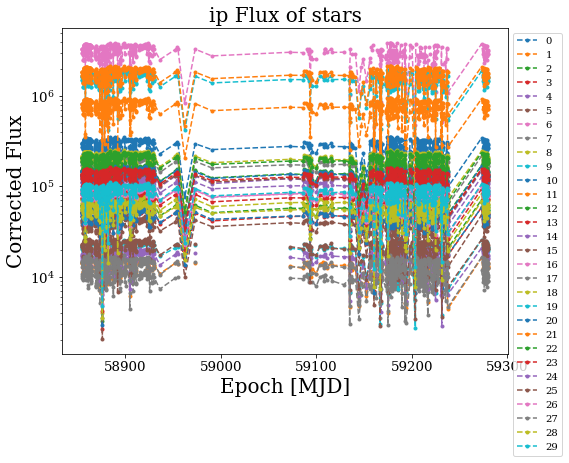

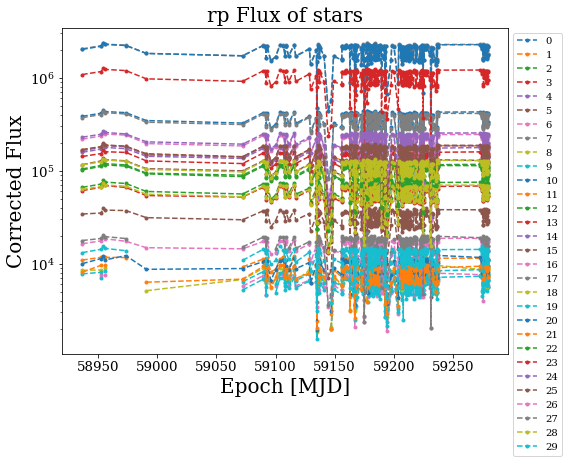

In [5]:
# Try the data
for f in filt:
    for s in range(N_stars):
        plt.plot(epoch[f],flux[f][:,s],linestyle='dashed',marker='.',label=s)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" Flux of stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()

# Extract magnitudes from Gaia DR2 & use for flux -> mag

In [6]:
# Extract the magnitudes from the stars in 400" radius around J0600
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Coords of J0600: 90.00316332976436 -31.007910088843165
coord = SkyCoord(ra=90.003163, dec=-31.007910, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(400, u.arcsec)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
r.pprint()


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2891196718939580672 ... 0.00013201426578689563
1635721458409799680 Gaia DR2 2891196684579844864 ...   0.009094052279059428
1635721458409799680 Gaia DR2 2891196753298345472 ...   0.010658205399898254
1635721458409799680 Gaia DR2 2891196684579845376 ...   0.011317279008876314
1635721458409799680 Gaia DR2 2891196753297490304 ...   0.012358430209092582
1635721458409799680 Gaia DR2 2891196920800325760 ...   0.013193050363307734
1635721458409799680 Gaia DR2 2891196753299317632 ...   0

In [7]:
# To link the correct Gaia entries to our stars, select star with nearest coordinates
filt2 = ['gp','rp']

def find_stars(xobj_list, yobj_list, xlist, ylist, f):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    """
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=4)
    plt.scatter(xobj_list, yobj_list, c='red', s=2)
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title(f)
    plt.show()
    """
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

def distance(xobj,yobj, xlist,ylist):
    'find the distance between target & objects round it, returns list with distances in pixels'
    d = (xobj-xlist)**2 + (yobj-ylist)**2
    return np.sqrt(d)

In [8]:
# Making a mask for the gaia data to extract the data from the relevant stars
gaiamask = {}
for f in filt:
    stars_arg, d = find_stars(star_coords[f][:,0],star_coords[f][:,1],np.array(r['ra']),np.array(r['dec']),f)
    gaiamask[f] = stars_arg
    max_d = 1 #if distance is bigger than 1", it is to much
    if np.sum(d >= max_d) != 0:
        print ("Stars that are too distant")
        print (f, np.arange(N_stars)[d >= max_d])
    plt.show()

# Making a dictionary for the gaia magnitude of the selected stars
gaia_mag = {}
gaia_mag[filt[0]] = np.array(r['phot_g_mean_mag'][gaiamask[filt[0]]]) #gaia filter g, not gp
gaia_mag[filt[2]] = np.array(r['phot_rp_mean_mag'][gaiamask[filt[2]]])


# Making a dictionary for the gaia colours for the selected stars in each filter (c=rp-g in this case)
gaia_c = {}
for f in filt:
    c = np.array(r['phot_rp_mean_mag'][gaiamask[f]]) - np.array(r['phot_g_mean_mag'][gaiamask[f]])
    gaia_c[f] = c


In [9]:
# Extract the Gaia J0600 data
# Coords of J0600: 90.00316332976436 -31.007910088843165
d = distance(90.00316332976436, -31.007910088843165, r['ra'],r['dec'])

J0600_gaia = r[np.argmin(d)]


# Extract gaia magnitudes & colour for J0600
J0600_gaiamag = {}
J0600_gaiamag[filt[0]] = J0600_gaia['phot_g_mean_mag'] #gaia filter g, not gp
J0600_gaiamag[filt[2]] = J0600_gaia['phot_rp_mean_mag']
print (J0600_gaiamag)

J0600_c = J0600_gaia['phot_rp_mean_mag']-J0600_gaia['phot_g_mean_mag']

{'gp': 13.146582, 'rp': 12.333511}


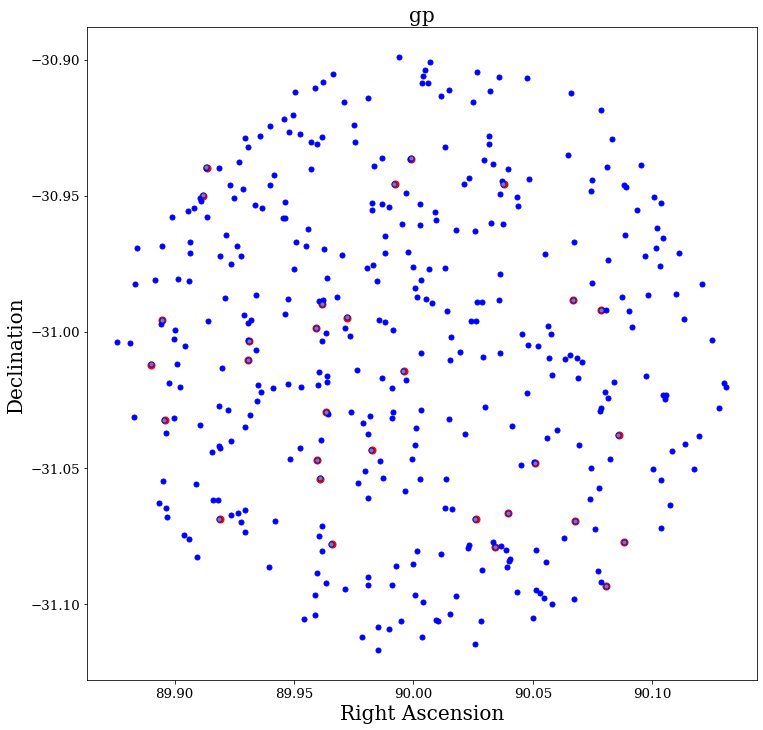

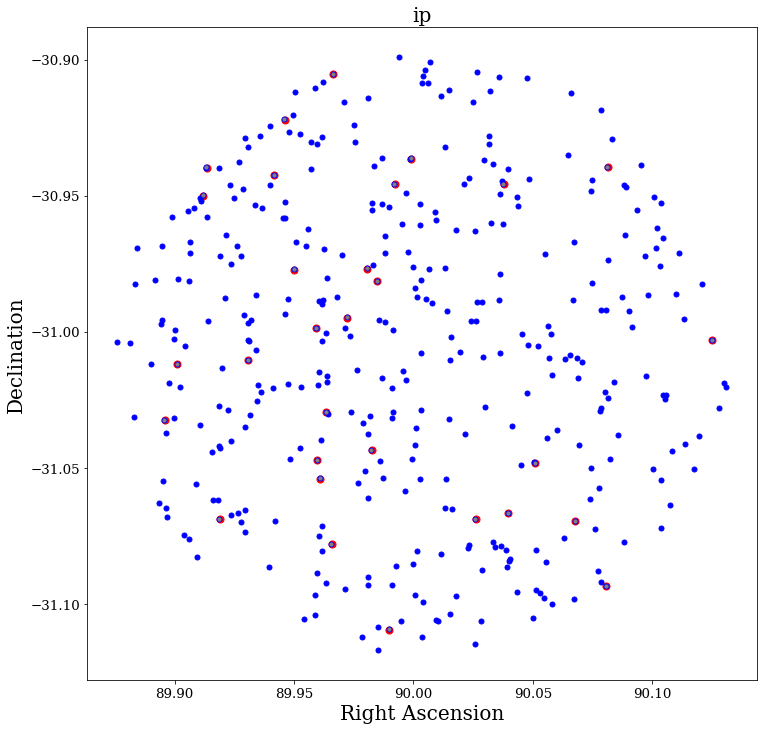

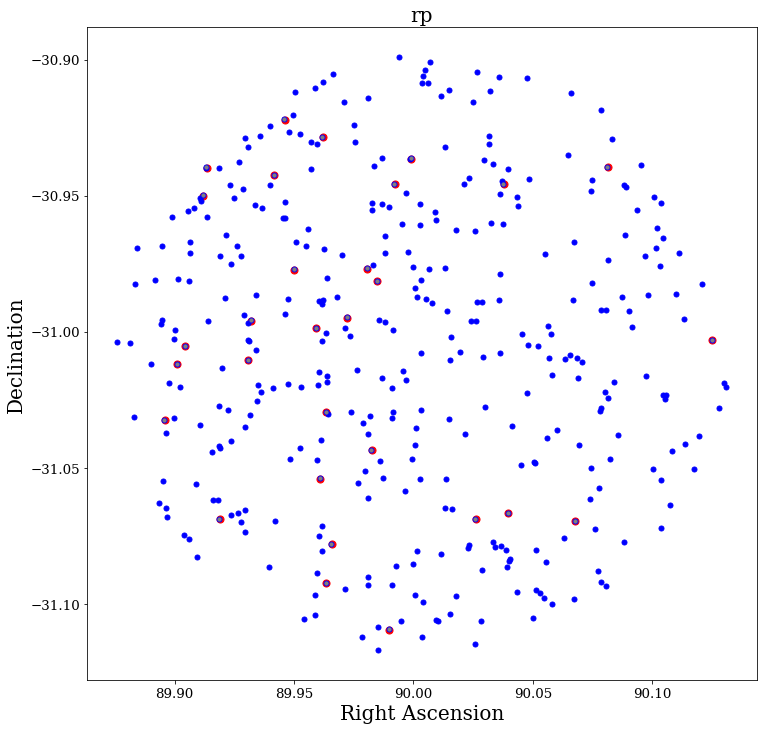

[[ 89.95974787 -31.04707369]
 [ 89.96086403 -31.05397864]
 [ 89.99208681 -30.94570388]
 [ 90.08588873 -31.03808911]
 [ 89.97216002 -30.99479154]
 [ 89.89585502 -31.03259231]
 [ 90.06759557 -31.06961968]
 [ 89.91189101 -30.94994371]
 [ 90.02605846 -31.06876748]
 [ 89.99908543 -30.93637772]
 [ 89.9825416  -31.04355034]
 [ 90.03772261 -30.94571025]
 [ 89.96570213 -31.07802613]
 [ 89.91885243 -31.06881143]
 [ 89.91341968 -30.93968853]
 [ 90.08078424 -31.09351133]
 [ 90.03977518 -31.06662634]
 [ 89.96163202 -30.98996781]
 [ 90.03410296 -31.0791985 ]
 [ 90.05091595 -31.04836256]
 [ 90.07857013 -30.99212042]
 [ 89.93094974 -31.01052551]
 [ 89.95929417 -30.9985892 ]
 [ 90.06677905 -30.98836797]
 [ 89.89479921 -30.99562367]
 [ 89.93111242 -31.00328648]
 [ 89.8902438  -31.01209221]
 [ 90.08831048 -31.0771588 ]
 [ 89.99586794 -31.0144916 ]
 [ 89.96344504 -31.02964364]]
[[ 89.99208681 -30.94570388]
 [ 89.96086403 -31.05397864]
 [ 90.08130988 -30.93959353]
 [ 89.97216002 -30.99479154]
 [ 89.9417683

In [10]:
# Make a plot to check if the right stars are selected
for f in filt:
    plt.figure(figsize=(12,12))
    #plt.scatter(standards['RA'][0],standards['Dec'][0], c='r',s=15)
    plt.scatter(star_coords[f][:,0],star_coords[f][:,1], c='r',s=50)
    plt.scatter(r['ra'],r['dec'],c='b',s=25)
    plt.scatter(r['ra'][gaiamask[f]],r['dec'][gaiamask[f]],c='grey',s=10)
    plt.xlabel("Right Ascension")
    plt.ylabel("Declination")
    #plt.axis(xmin=89.90,xmax=89.94,ymin=-30.96,ymax=-30.92)
    #plt.axis(xmin=89.86,xmax=90.01,ymin=-31.02,ymax=-30.88)
    plt.title(f)
    plt.show()

# Look in datafiles if overexposed stars are included: The brightest star is in some images overexposed
for f in ['gp','rp']:
    tmp = np.argsort(gaia_mag[f])
    print (np.array([star_coords[f][:,0][tmp],star_coords[f][:,1][tmp]]).transpose())

# 5h 59m 53.3s.

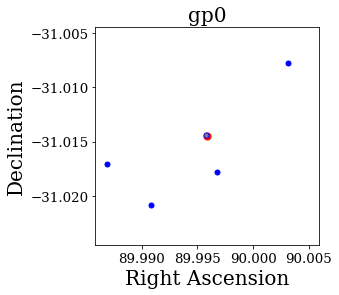

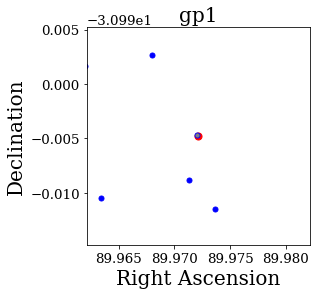

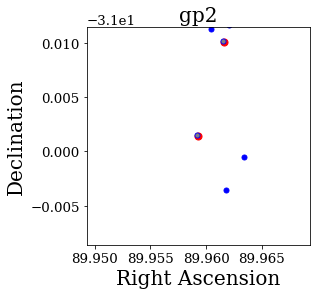

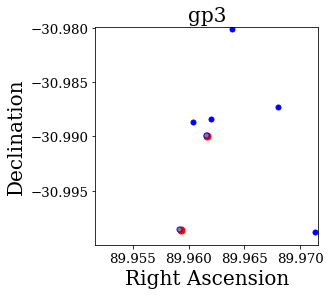

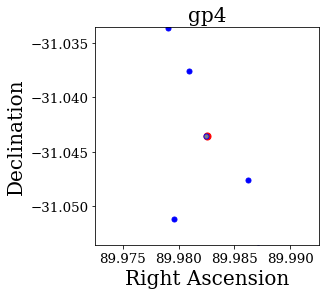

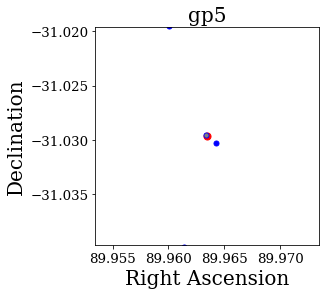

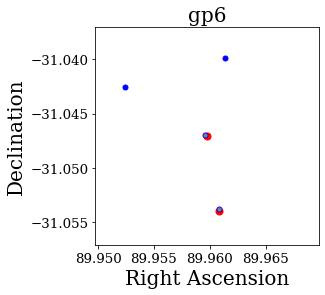

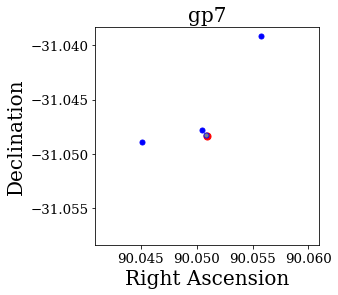

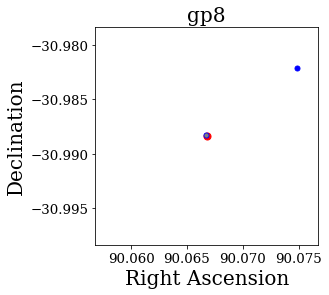

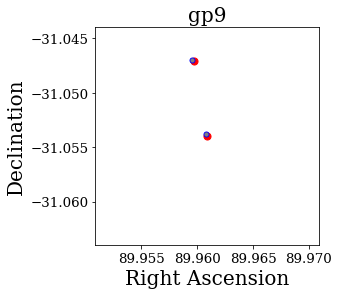

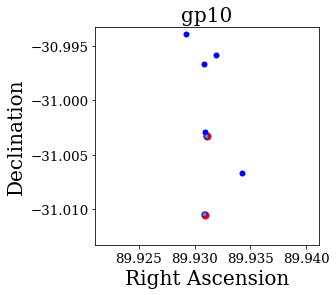

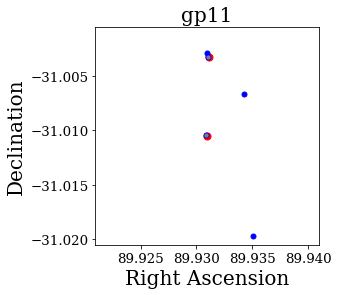

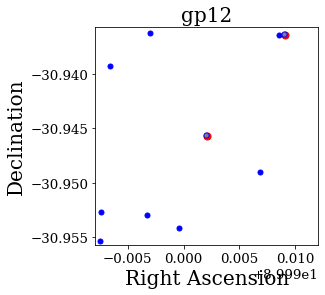

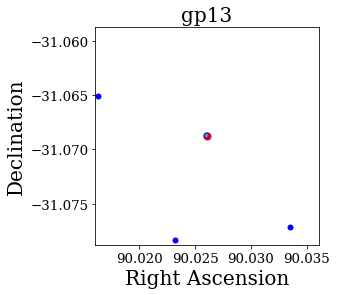

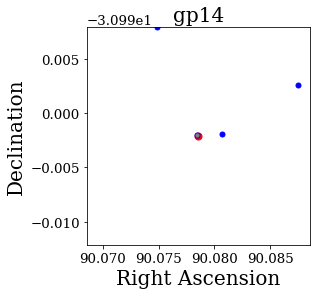

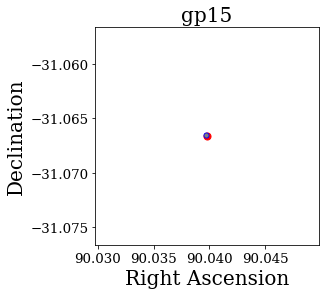

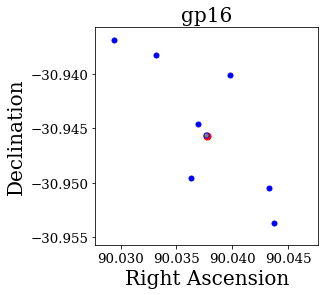

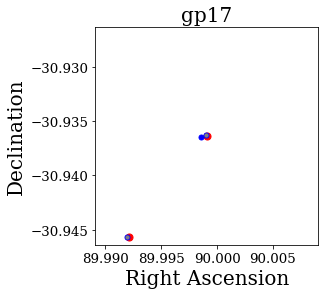

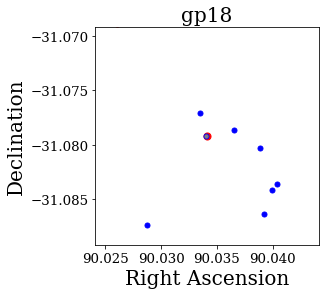

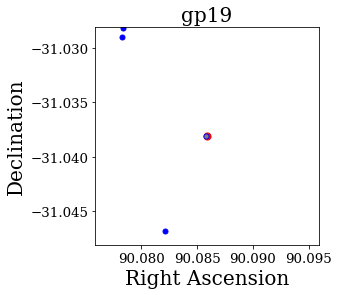

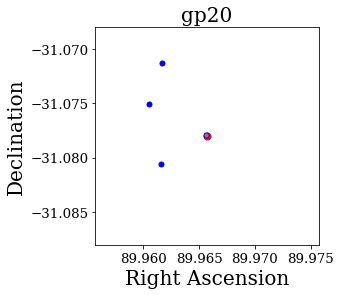

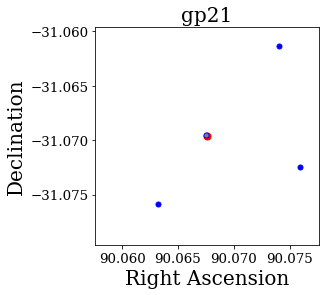

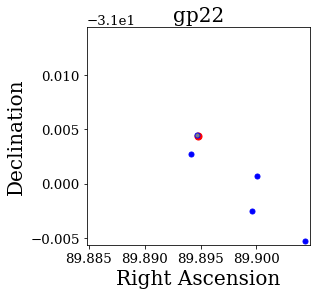

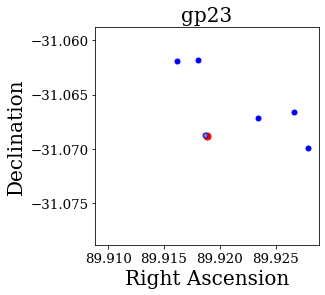

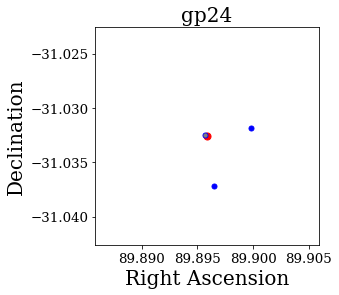

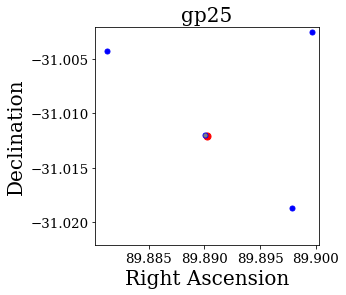

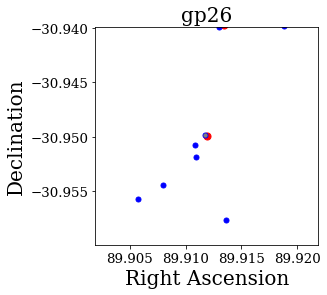

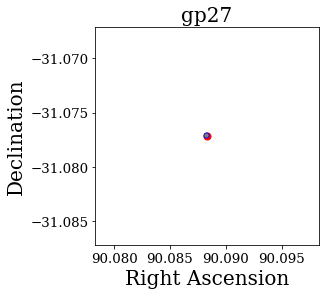

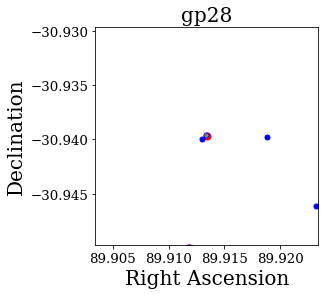

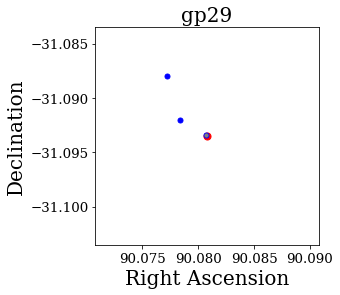

In [11]:
# Look carefully at small region around stars to see if the right one is selected
# Make a plot to check if the right stars are selected
for f in ['gp']:
    for s in range(N_stars):
        plt.figure(figsize=(4,4))
        #plt.scatter(standards['RA'][0],standards['Dec'][0], c='r',s=15)
        plt.scatter(star_coords[f][:,0],star_coords[f][:,1], c='r',s=50)
        plt.scatter(r['ra'],r['dec'],c='b',s=25)
        plt.scatter(r['ra'][gaiamask[f]],r['dec'][gaiamask[f]],c='grey',s=10)
        plt.xlabel("Right Ascension")
        plt.ylabel("Declination")
        
        plt.xlim(star_coords[f][s,0]-0.01,star_coords[f][s,0]+0.01)
        plt.ylim(star_coords[f][s,1]-0.01,star_coords[f][s,1]+0.01)
        #plt.axis(xmin=,xmax=89.94,ymin=-30.96,ymax=-30.92)
        #plt.axis(xmin=89.86,xmax=90.01,ymin=-31.02,ymax=-30.88)
        plt.title(f + str(s))
        plt.show()


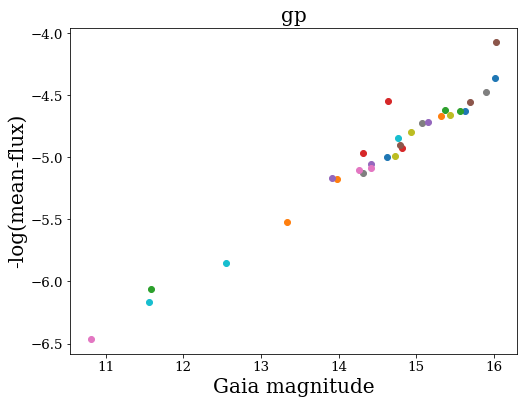

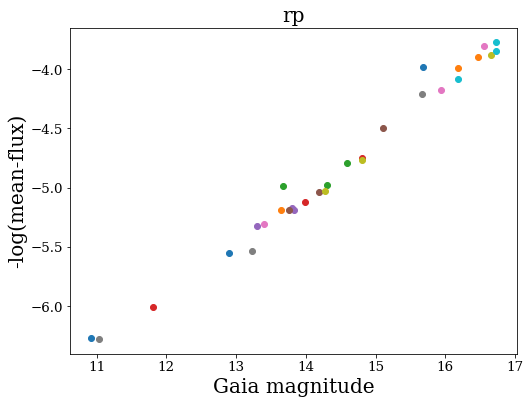

30


In [12]:
# Making a plot of the gaia magnitude on x-axis and -log(meanflux) on the y axis for selected stars
#  if all is well, this should result in a straight line.

for f in filt2:
    for s in range(N_stars):
        nonNaN = np.isnan(flux[f][:,s])==False
        plt.scatter(gaia_mag[f][s],-1*np.log10(np.mean(flux[f][:,s][nonNaN])))
    plt.title(f)
    plt.xlabel("Gaia magnitude")
    plt.ylabel("-log(mean-flux)")
    plt.show()
print (len(gaia_mag['gp']))

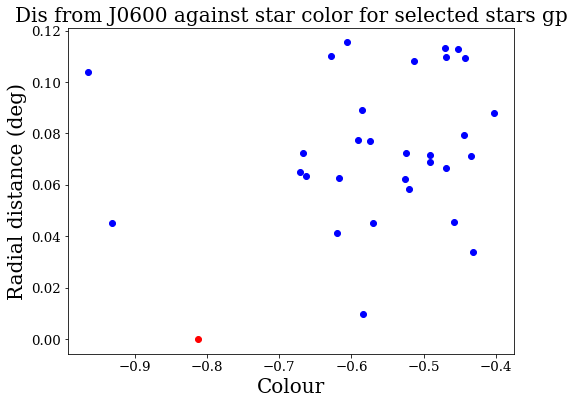

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


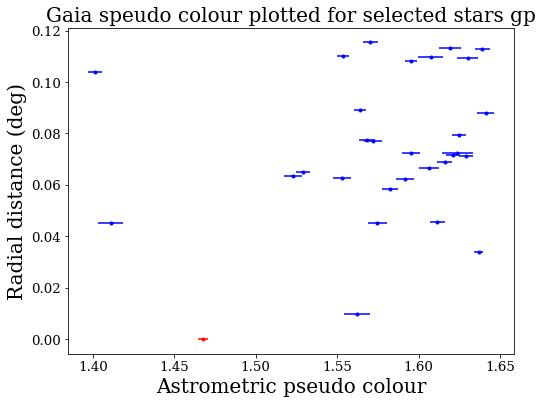

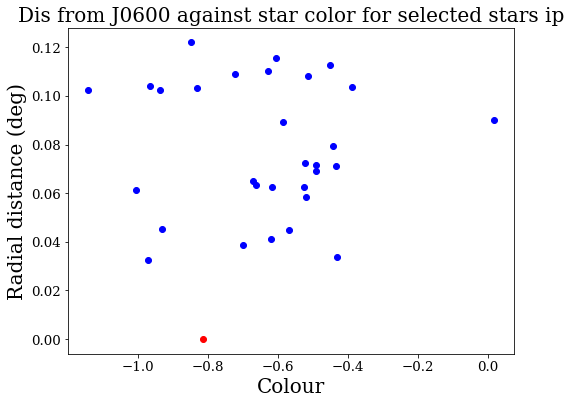

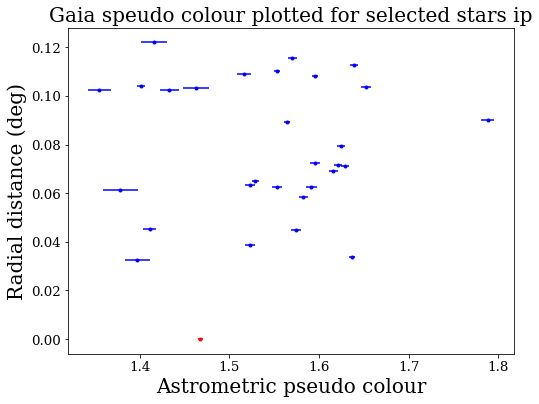

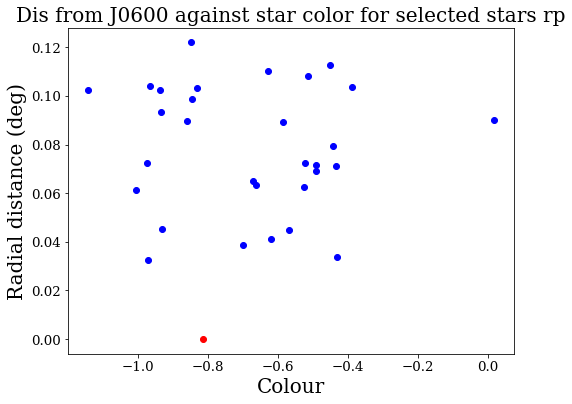

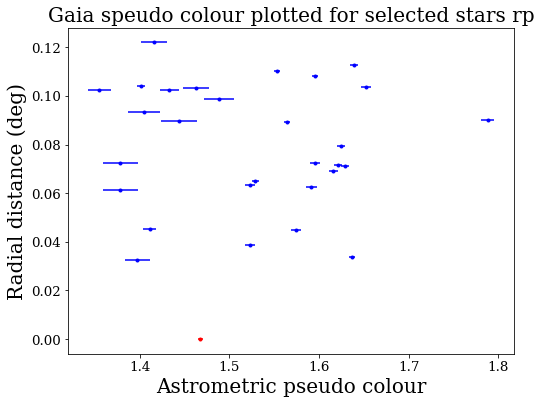

In [13]:
# Radial distance to J0600 plotted as function of colour

for f in filt:
    d_to_J0600 = distance(90.00316332976436, -31.007910088843165,r['ra'][gaiamask[f]],r['dec'][gaiamask[f]])
    
    plt.scatter(gaia_c[f], d_to_J0600,c='b')
    plt.scatter(J0600_c,0,c='r')
    plt.xlabel('Colour')
    plt.ylabel('Radial distance (deg)')
    plt.title('Dis from J0600 against star color for selected stars '+f)
    plt.show()

    plt.errorbar(r['astrometric_pseudo_colour'][gaiamask[f]], d_to_J0600,\
                 xerr = r['astrometric_pseudo_colour_error'][gaiamask[f]],fmt='.', c='b')
    plt.errorbar(J0600_gaia['astrometric_pseudo_colour'],0,\
                 xerr=J0600_gaia['astrometric_pseudo_colour_error'],fmt='.',c='r')
    plt.xlabel('Astrometric pseudo colour')
    plt.ylabel('Radial distance (deg)')
    plt.title('Gaia speudo colour plotted for selected stars '+f)
    plt.show()

c_mask = {}
for f in filt:
    c_mask[f] = gaia_c[f] < J0600_c

# Fitting the atmospheric extinction model to the data

[26.91086435]
[[0.00227275]]


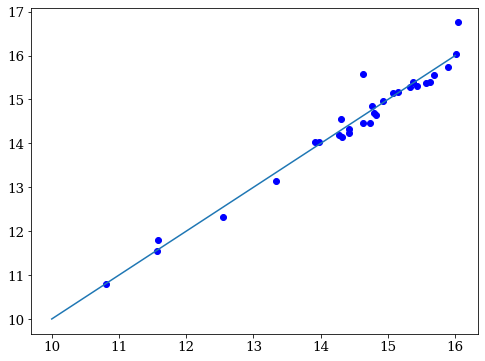

[26.48876522]
[[0.00313403]]


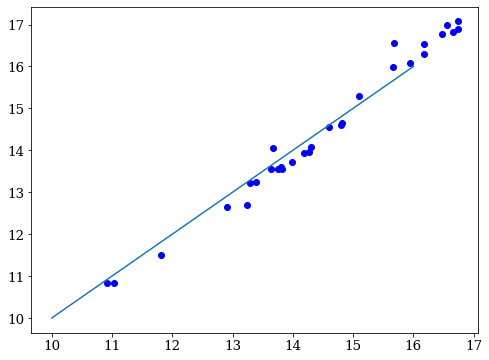

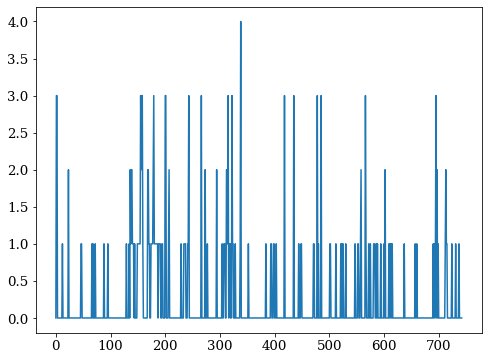

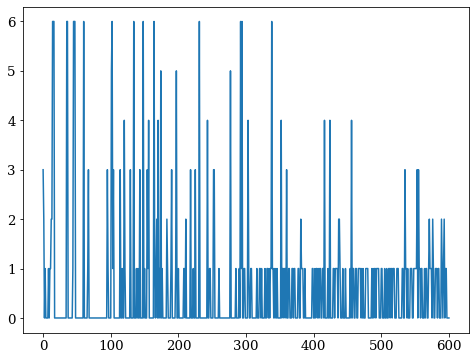

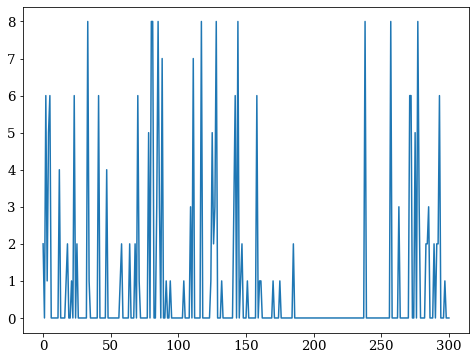

In [14]:
# calculating guess for zeropoint:
def linear(x,b):
    return x+b

# Convert the fluxes to 'magnitudes' with mx = -2.5*log_10(Flux)
mx = {}
mxerr = {}
mmx = {}
for f in filt:
    mx[f] = -2.5*np.log10(flux[f])
    mxerr[f] = (2.5/np.log(10)) * (fluxerr[f]/flux[f])
    #mxerr_J0600[f] = 2.5*J0600_fluxerr[f]/J0600_flux[f]*1/np.log(10)
    tmp = []
    for s in range(N_stars):
        nonNaN = np.isnan(mx[f][:,s]) == False
        mm = np.mean(mx[f][:,s][nonNaN])
        tmp.append(mm)
    mmx[f] = np.array(tmp)   

mx_J0600 = {}
mxerr_J0600 = {}
for f in filt:
    mx_J0600[f] = -2.5*np.log10(J0600_flux[f])
    mxerr_J0600[f] = (J0600_fluxerr[f]/J0600_flux[f])*(2.5/np.log(10))

x = np.linspace(10,16,100)
for f in filt2:
    popt, pcov = optimize.curve_fit(linear, mmx[f], gaia_mag[f])
    print (popt)
    print (pcov)

    plt.scatter(gaia_mag[f],mmx[f]+popt,c='b')
    plt.plot(x,x)
    plt.show()

for f in filt:
    plt.plot(np.sum(np.isnan(mx[f]),axis=1))
    plt.show()

In [105]:
from scipy import optimize


def atmosph_ext(mx, a0, a1, a2):#, a3, a4):#, a5, a6):#, a7, a8, a9, a10, a11, a12): # (*might* be overkill to use all)
    lst = [a0, a1, a2]#, a3, a4]#, a5, a6]#, a7, a8, a9, a10, a11, a12]
    
    return_val = 0
    return_val =+ mx + a0
    for i in range(1,N_fit_params):
        return_val += c**i * lst[i]
    
    return return_val

N_fit_params = 3

fit_result = {}
fit_resulterr = {}
for f in filt2:
    tmp = []
    tmp2 = []
    for e in range(len(epoch[f])):
        nonNaN = np.isnan(mx[f][e]) == False
        
        X = airmass[f][e]
        M = mx[f][e][nonNaN]
        c = (gaia_c[f])[nonNaN]
        
        #popt, pcov = optimize.curve_fit(atmosph_ext,M, gaia_mag[f][nonNaN], p0=[27,0,0],\
        #                                bounds=([0,-0.02,-0.02],[50,0.02,0.02],))
        #popt, pcov = optimize.curve_fit(atmosph_ext,M, gaia_mag[f][nonNaN], p0=[27,0,0],\
        #                                bounds=([0,-10,-10],[50,10,10]))
        
        popt, pcov = optimize.curve_fit(atmosph_ext,M, gaia_mag[f][nonNaN], p0=[27]+ ([0]*(N_fit_params-1)),\
                                       bounds=([-10]+([-10]*(N_fit_params-1)),[50]+([10]*(N_fit_params-1))))
        
        
        tmp.append(np.array(popt))
        tmp2.append(np.sqrt(np.diag(pcov)))
    fit_result[f] = np.array(tmp)
    fit_resulterr[f] = np.array(tmp2)


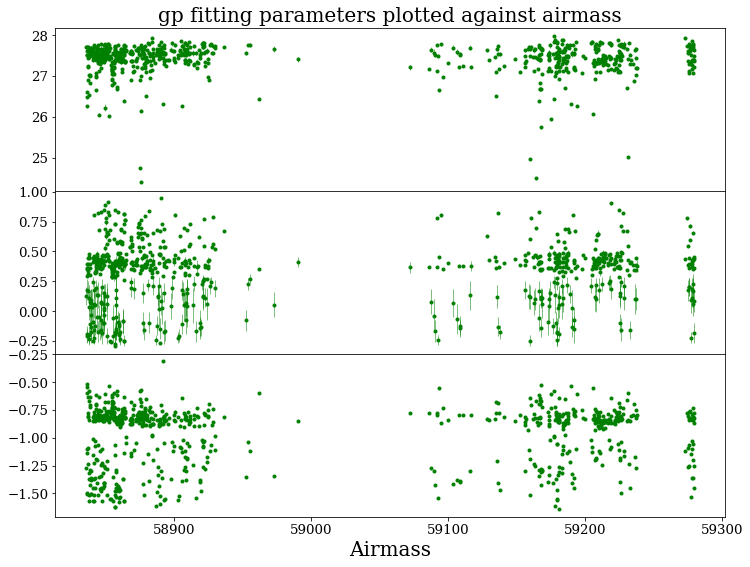

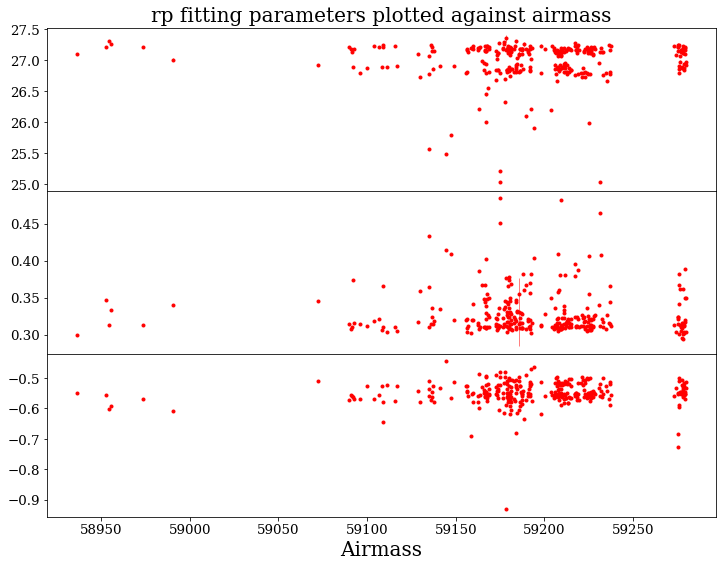

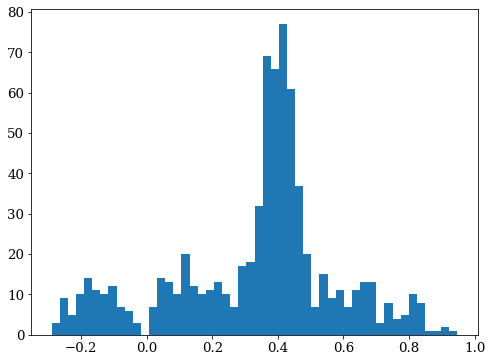

Median a1 filter gp = 0.38857
Median a2 filter gp = -0.84370
Median a1 filter rp = 0.31684
Median a2 filter rp = -0.55062


In [106]:
tmp1 = ['a0','a1','a2','a3','a4','a5','a6','a7','a8']
tmp2 = {'gp':'g','ip':'pink','rp':'r'}

for f in filt2:
    fig, axs = plt.subplots(N_fit_params, sharex=True, gridspec_kw={'hspace': 0})
    fig.set_figheight(3*N_fit_params)
    fig.set_figwidth(12)
    for i in range(N_fit_params):
        axs[i].errorbar(epoch[f], fit_result[f][:,i],yerr=fit_resulterr[f][:,i],fmt='.',linewidth=0.5,c=tmp2[f])
        #axs[i].errorbar(airmass[f], fit_result[f][:,i],fmt='.',linewidth=0.2,c=tmp2[f])
        #axs[i].set_ylim([-.01,.01])
        #axs[i].set_ylim([-.001,.001])
    axs[N_fit_params-1].set_xlabel("Airmass")
    #axs[N_fit_params-1].set_xlim([0.99,1.61])
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    axs[0].set_title(f+' fitting parameters plotted against airmass')
plt.show()

#making a histogram of the second and third fit parameter to determine the middle
f = 'gp'
plt.hist(fit_result[f][:,1],bins=50)
plt.show()
for f in filt2:
    for i in [1,2]:
        print ("Median {} filter {} = {:.5f}".format(tmp1[i],f,np.median(fit_result[f][:,i])))

In [109]:
# Calculate magnitude and mean magnitude for all fit parameters
mag = {}
magerr = {}
for f in filt2:
    c = gaia_c[f]
    tmp = []
    tmp2 = []
    for e in range(len(epoch[f])):
        X = airmass[f][e]
        m = atmosph_ext(mx[f][e],*fit_result[f][e])
        tmp.append(m)
        
        fit_param_propagatederr = 0
        #for i in range(N_fit_params):
        #    fit_param_propagatederr += ((c**i)*fit_resulterr[f][e][i])**2
        merr = np.sqrt(((mxerr[f][e])**2) + fit_param_propagatederr)
        
        tmp2.append(merr)
    mag[f] = np.array(tmp)
    magerr[f] = np.array(tmp2)


J0600_mag = {}
J0600_magerr = {}
for f in filt2:
    c = J0600_c
    tmp = []
    tmp2 = []
    for e in range(len(epoch[f])):
        X = airmass[f][e]
        m = atmosph_ext(mx_J0600[f][e],*fit_result[f][e])
        
        fit_param_propagatederr = 0
        #for i in range(N_fit_params):
        #    fit_param_propagatederr += ((c**i)*fit_resulterr[f][e][i])**2
        merr = np.sqrt(((mxerr_J0600[f][e])**2) + fit_param_propagatederr)
        
        tmp.append(m)
        tmp2.append(merr)
    J0600_mag[f] = np.array(tmp)
    J0600_magerr[f] = np.array(tmp2)

J0600_mmag = {}
for f in filt2:
    nonNaN = np.isnan(J0600_mag[f]) == False
    J0600_mmag[f] = np.mean(J0600_mag[f][nonNaN])

mmag = {}
for f in filt2:
    tmp = []
    for s in range(N_stars):
        nonNaN = np.isnan(mag[f][:,s]) == False
        mm = np.median(mag[f][:,s][nonNaN])
        tmp.append(mm)
    mmag[f] = np.array(tmp)


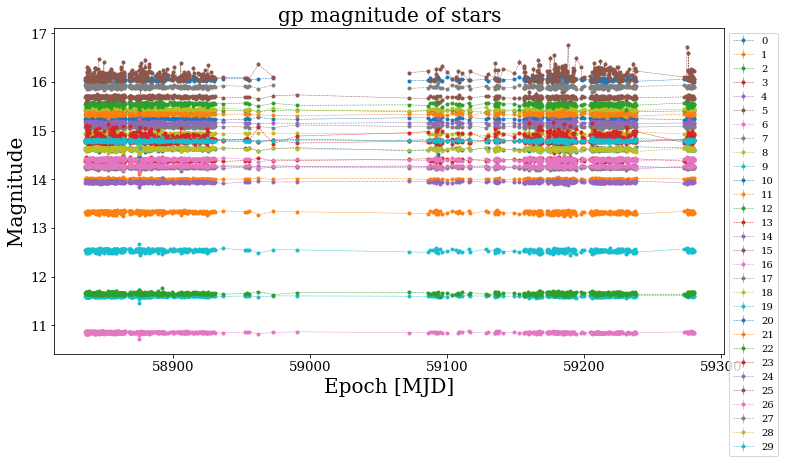

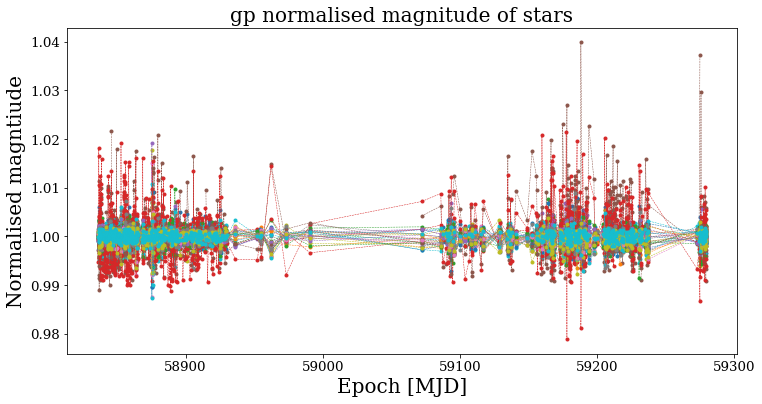

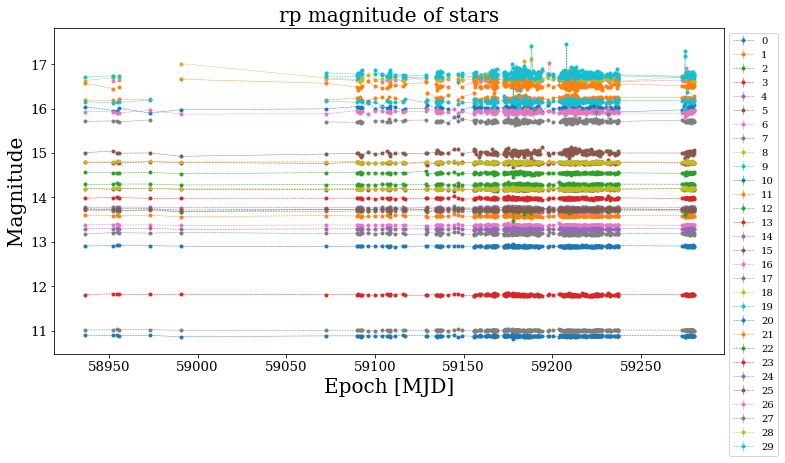

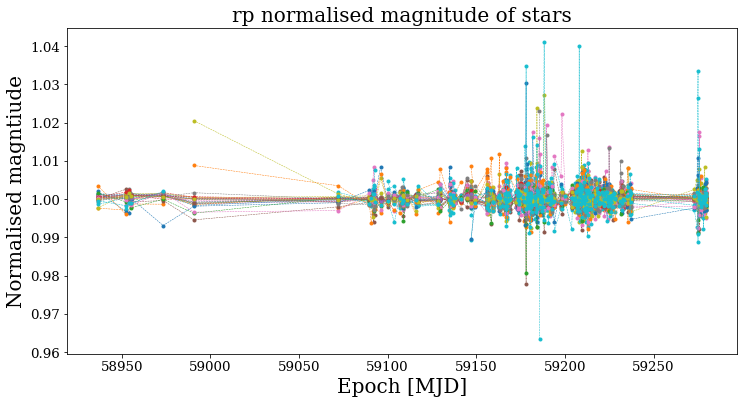

266
0
58876.1230796
(array([272]),)


In [77]:
tmp = {'gp':[15.75,10.5],'rp':[15,10.75]}

for f in filt2:
    plt.figure(figsize=(12,6))
    for s in range(N_stars):
        plt.errorbar(epoch[f],mag[f][:,s],yerr=magerr[f][:,s], fmt='--.',linewidth=0.5,label=s)
        #plt.errorbar(epoch[f],mag[f][:,s], fmt='--.',linewidth=0.5)#,label=s)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" magnitude of stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Magnitude")
    #plt.axis(ymin=tmp[f][0], ymax=tmp[f][1],xmin=epoch[f][0]-1,xmax=epoch[f][-1]+1)
    plt.show()
    plt.figure(figsize=(12,6))
    for s in range(N_stars):
        plt.errorbar(epoch[f],mag[f][:,s]/mmag[f][s],\
                     fmt='--.', linewidth=0.5,label=s+1)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised magnitude of stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Normalised magntiude")
    #plt.axis(ymin=0.995,ymax=1.005,xmin=epoch[f][0]-1,xmax=epoch[f][-1]+1)
    plt.savefig('../Slide_pics/Atmospheric-extinction-corrected-normalised_flux_'+f)
    plt.show()

f='gp'
nonNaN = np.isnan(mag[f][:,17]/mmag[f][s]) == False
print (np.argmax(mag[f][:,17]/mmag[f][s]))
print (np.sum(nonNaN == False))
print (epoch[f][nonNaN][272])
print (np.where(epoch[f][nonNaN][272] == epoch[f]))

In [69]:
# get histogram for stellar lines
#f = 'gp'
#for s in range(N_stars):
#    plt.hist(mag[f][:,s]/mmag[f][s], bins=50,range=(0.99,1.01))
#    plt.title(f+str(s))
#    plt.show()

In [78]:
"""
for f in filt2:
    for s in np.arange(N_stars):#[c_mask[f]]:
        plt.figure(figsize=(16,4))
        plt.plot([0,1e6],[1,1],c='r',linestyle='dashed')
        plt.errorbar(epoch[f],mag[f][:,s]/mmag[f][s],yerr=magerr[f][:,s]/mmag[f][s],\
                     fmt='--.',linewidth=0.5,c='b')#,label=s)
        #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        if c_mask[f][s] == True:
            plt.title(f+" magnitude of star "+str(s)+" SELECTED BY COLOUR")
        else:
            plt.title(f+" magnitude of star "+str(s))
        plt.xlabel("Epoch [MJD]")
        plt.ylabel("normalised magnitude")
        plt.xlim(xmin=np.min(epoch[f]),xmax=np.max(epoch[f]))#58930)
        #plt.xlim(xmin=0.99,xmax=1.6)
        plt.ylim(ymin=0.995,ymax=1.005)
        #plt.yscale('log')
        plt.show()
"""
#for f in filt2:
#    for s in range(N_stars):
#        plt.figure(figsize=(10,4))
#        plt.plot([0,1e6],[1,1],c='r',linestyle='dashed')
#        plt.plot(epoch[f],magnitude[f][:,s]/mmag[f][s],linestyle='dashed',marker='.',linewidth=0.5)#,label=s)
#        #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
#        plt.title(f+" magnitude of star "+str(s))
#        plt.xlabel("Epoch [MJD]")
#        plt.ylabel("Magnitude")
#        plt.axis(ymin=0.95,ymax=1.05, xmax=epoch[f][-1],xmin=epoch[f][0])#59100)
        #plt.yscale('log')
#        plt.show()

'\nfor f in filt2:\n    for s in np.arange(N_stars):#[c_mask[f]]:\n        plt.figure(figsize=(16,4))\n        plt.plot([0,1e6],[1,1],c=\'r\',linestyle=\'dashed\')\n        plt.errorbar(epoch[f],mag[f][:,s]/mmag[f][s],yerr=magerr[f][:,s]/mmag[f][s],                     fmt=\'--.\',linewidth=0.5,c=\'b\')#,label=s)\n        #plt.legend(bbox_to_anchor=(1, 1), loc=\'upper left\')\n        if c_mask[f][s] == True:\n            plt.title(f+" magnitude of star "+str(s)+" SELECTED BY COLOUR")\n        else:\n            plt.title(f+" magnitude of star "+str(s))\n        plt.xlabel("Epoch [MJD]")\n        plt.ylabel("normalised magnitude")\n        plt.xlim(xmin=np.min(epoch[f]),xmax=np.max(epoch[f]))#58930)\n        #plt.xlim(xmin=0.99,xmax=1.6)\n        plt.ylim(ymin=0.995,ymax=1.005)\n        #plt.yscale(\'log\')\n        plt.show()\n'

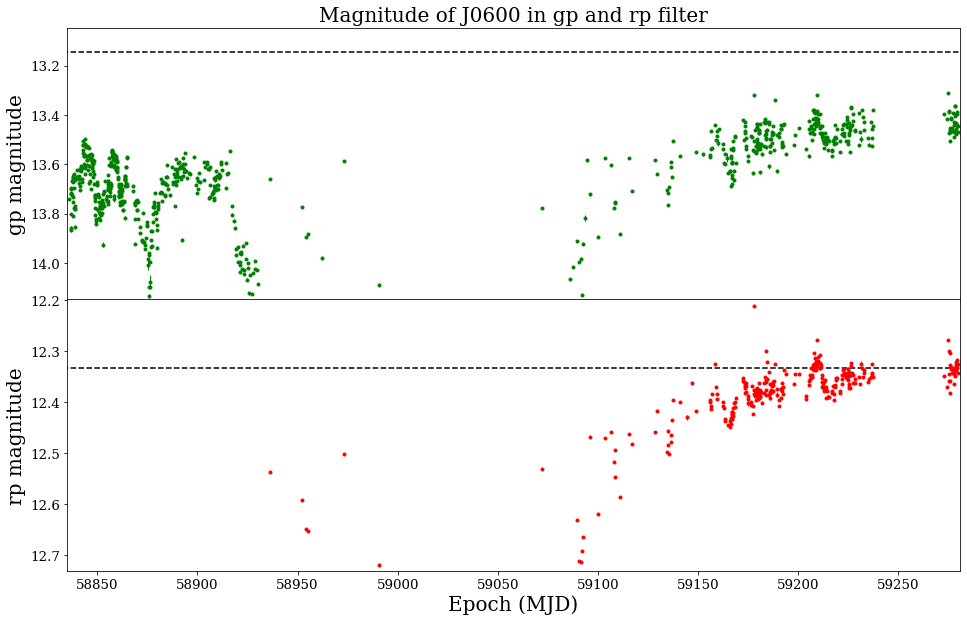

In [110]:
#for f in filt2:
#    plt.plot(epoch[f],J0600_magnitude[f], linestyle='dashed',linewidth=0.5,marker='.')
    
    #plt.axis(ymin = np.max(J0600_magnitude[f][nonNaN]), ymax=np.min(J0600_magnitude[f][nonNaN]))
#    plt.show()
mask = {}
for f in filt2:
    mask[f] = airmass[f]<1.42

tmp2 = {'gp':'g','rp':'r'}

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Magnitude of J0600 in gp and rp filter ')
fig.set_figheight(10)
fig.set_figwidth(16)
f = 'gp'
axs[0].set_title('Magnitude of J0600 in gp and rp filter')
axs[0].plot([0,1e6],[J0600_gaiamag[f],J0600_gaiamag[f]],c='black',linestyle='dashed')
axs[0].errorbar(epoch[f], J0600_mag[f], yerr=J0600_magerr[f], fmt='.',linewidth=1,c=tmp2[f])
#axs[0].plot([0,1e6],[J0600_gaia['phot_g_mean_mag'],J0600_gaia['phot_g_mean_mag']],linestyle='dashed',c='black')
axs[0].set_ylim([1.001*np.max(J0600_mag[f]),0.98*np.min(J0600_mag[f])])
axs[0].set_ylabel("gp magnitude")
axs[1].set_xlim([epoch[f][0]-1,epoch[f][-1]+1])
f = 'rp'
axs[1].plot([0,1e6],[J0600_gaiamag[f],J0600_gaiamag[f]],c='black',linestyle='dashed')
axs[1].errorbar(epoch[f], J0600_mag[f], yerr=J0600_magerr[f], fmt='.',linewidth=1,c=tmp2[f])
#axs[1].plot([0,1e6],[J0600_gaia['phot_rp_mean_mag'],J0600_gaia['phot_rp_mean_mag']],linestyle='dashed',c='black')
axs[1].set_ylim([1.001*np.max(J0600_mag[f]),0.999*np.min(J0600_mag[f])])
axs[1].set_ylabel("rp magnitude")
axs[1].set_xlabel("Epoch (MJD)")

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [113]:
# Export these curves to a file

# Write out the meta_data elements to a file
#filecontent = Table([t_image,t_newimg, t_epoch, t_filter, t_airmass], \
#                    names=['IMAGE','NEWIMG','EPOCH','FILTER','AIRMASS'])
#filepath = "..//datared/J0600_meta-data.txt"
#ascii.write(filecontent, filepath, overwrite=True)


#axs[0].errorbar(epoch[f], J0600_mag[f], yerr=mxerr_J0600[f], fmt='.',linewidth=1,c=tmp2[f])
#axs[1].errorbar(epoch[f], J0600_mag[f], yerr=mxerr_J0600[f], fmt='.',linewidth=1,c=tmp2[f])

for f in filt2:
    filepath = "J0600_"+f+".txt"
    filecontent = Table([epoch[f], airmass[f], J0600_mag[f], J0600_magerr[f]],\
                       names=["EPOCH","AIRMASS","MAG","MAGERR"])
    ascii.write(filecontent, filepath, overwrite=True)




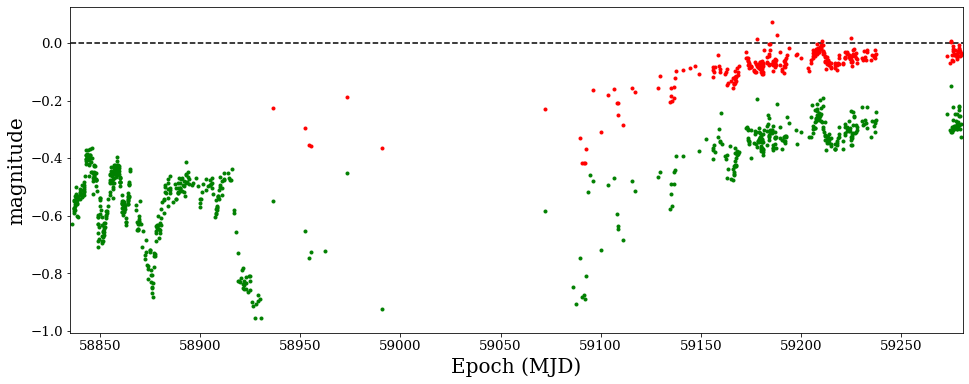

In [98]:
tmp2 = {'gp':'g','ip':'pink','rp':'r'}

plt.figure(figsize=(16,6))
plt.plot([0,1e6],[0,0],c='black',linestyle='dashed')
for f in filt2:
    plt.errorbar(epoch[f], J0600_gaiamag[f] - J0600_mag[f], fmt='.',linewidth=0.5,c=tmp2[f])
plt.xlim([epoch['gp'][0]-1,epoch['gp'][-1]+1])
plt.xlabel("Epoch (MJD)")
plt.ylabel("magnitude")
plt.show()

# Try to create an ip J0600 lightcurve (does not work)

def mag2(mx, a1):#, a2):
    return mx + (a1*c) #+ (a2*(c**2))

#calculate magnitude of i (without magnitude ZP)
f = 'ip'

a1_est = (np.median(fit_result['gp'][:,1]) + np.median(fit_result['rp'][:,1]))/2
a2_est = (np.median(fit_result['gp'][:,2]) + np.median(fit_result['rp'][:,2]))/2
print (a1_est,a2_est)

tmp = []
for e in range(len(epoch[f])):
    m = mag2(mx[f][e], a1_est)
    tmp.append(m)
i_mag = np.array(tmp)
#print (i_mag)

#calculate meanmag of i without ZP
tmp = []
for s in range(N_stars):
    nonNaN = np.isnan(i_mag[:,s]) == False
    mm = np.median(i_mag[:,s][nonNaN])
    tmp.append(mm)
i_mmag = np.array(tmp)
#print (i_mmag)

#calculate mean on a given day (normalisation factor)
tmp = []
for e in range(len(epoch[f])):
    nonNaN = np.isnan(i_mag[e]) == False
    nfac = np.median((i_mag[e]/i_mmag)[nonNaN])
    tmp.append(nfac)
normfac = np.array(tmp)
#print (normfac)

#calculate magnitude with constructed i
tmp = []
for s in range(N_stars):
    normm = i_mag[:,s]/normfac
    tmp.append(normm)
i_normmag = np.array(tmp).transpose()
print (i_normmag)
print (np.shape(i_normmag))

f = 'ip'
plt.figure(figsize=(12,6))
for s in range(N_stars):
    plt.errorbar(epoch[f],i_normmag[:,s], fmt='--.',linewidth=0.5)#,label=s)
    #plt.errorbar(corepoch[f],cormag[f][:,s], fmt='--.',linewidth=0.5)#,label=s)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title(f+" magnitude of stars")
plt.xlabel("Epoch [MJD]")
plt.ylabel("Magnitude")
#plt.axis(ymin=tmp[f][0], ymax=tmp[f][1],xmin=corepoch[f][0]-1,xmax=corepoch[f][-1]+1)
plt.show()

"""
plt.figure(figsize=(12,6))
for s in range(N_stars):
    plt.errorbar(corepoch[f],cormag[f][:,s]/mmag[f][s],\
                 fmt='--.', linewidth=0.5,label=s+1)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title(f+" normalised magnitude of stars")
plt.xlabel("Epoch [MJD]")
plt.ylabel("Normalised magntiude")
plt.axis(ymin=0.995,ymax=1.005,xmin=corepoch[f][0]-1,xmax=corepoch[f][-1]+1)
plt.savefig('../Slide_pics/Atmospheric-extinction-corrected-normalised_flux_'+f)
plt.show()"""

# Plot $\Delta$gp vs $\Delta$rp to see if dustsize varies throughout eclipse

In [56]:
#Use Interpolate to map rp datapoints on gp
#Use color of datapoints in plot to signal epoch
from scipy import interpolate

f1 = interpolate.interp1d(epoch['rp'],J0600_mag['rp'])
f2 = interpolate.interp1d(epoch['gp'],J0600_mag['gp'])

m1 = epoch['gp'] > 59050#np.min(epoch['rp']) # or 59050 as max epoch
m2 = epoch['gp'] < np.max(epoch['rp'])
J0600_rp_interp = f1(epoch['gp'][m1*m2])

m3 = epoch['rp'] > 59050
m4 = epoch['rp'] < np.max(epoch['gp'])
J0600_gp_interp = f2(epoch['rp'][m3*m4])


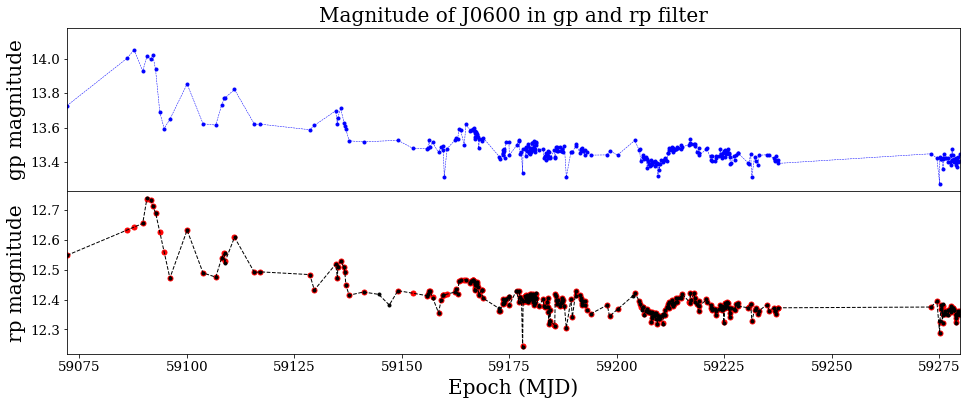

In [57]:
# Plot the interpolated data to test if it worked
# Black dots & line are original rp data, red is interpolated data on gp epoch's

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
fig.set_figheight(6)
fig.set_figwidth(16)
axs[0].set_title('Magnitude of J0600 in gp and rp filter')
axs[0].plot(epoch['gp'],J0600_mag['gp'],marker='.',linestyle='dashed',linewidth=0.5,c='b')
axs[0].set_ylabel("gp magnitude")

axs[1].plot(epoch['gp'][m1*m2], J0600_rp_interp, marker='o',linestyle='',c='r',markersize=5)
axs[1].plot(epoch['rp'],J0600_mag['rp'],marker='.',linestyle='dashed',linewidth=1,c='black',markersize=6)
axs[1].set_ylabel("rp magnitude")
axs[1].set_xlabel("Epoch (MJD)")
axs[1].set_xlim(np.min(epoch['gp'][m1*m2]),np.max(epoch['gp'][m1*m2]))

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

#plt.figure(figsize=(16,8))
#plt..plot(epoch['gp'],J0600_mag['gp'],marker='.',linestyle='dashed',linewidth=0.5,c='b')
#plt.plot(epoch['gp'][m1*m2], J0600_rp_interp, marker='o',linestyle='',c='r')
#plt.plot(epoch['rp'],J0600_mag['rp'],marker='.',linestyle='dashed',linewidth=1,c='black')

#plt.xlim(np.min(epoch['gp'][m1*m2]),np.max(epoch['gp'][m1*m2]))
#plt.grid()
#plt.show()
#print (np.shape(test))

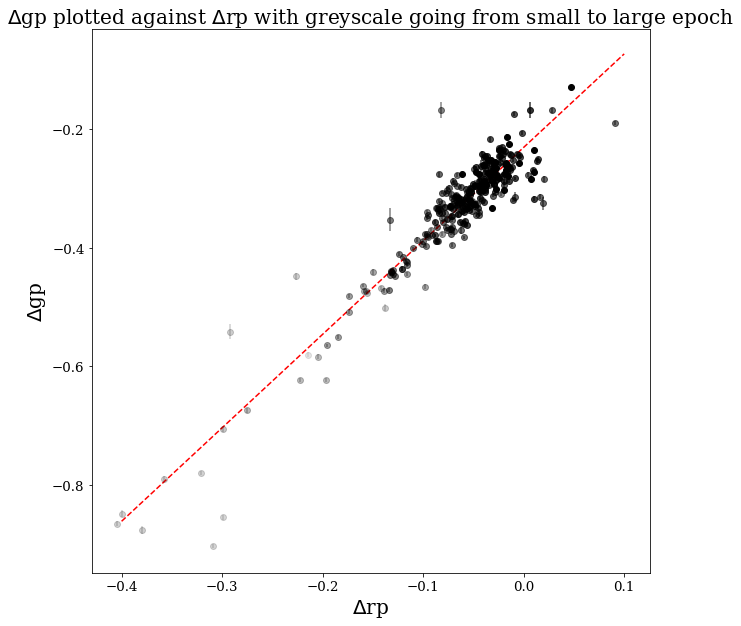

Optimal line through points: a*x + b with a = 1.57894, b = -0.230395
Variance = 0.21271
Standard deviation = 0.46121


In [58]:
def linear2(x,a,b):
    return x*a + b
popt, pcov = optimize.curve_fit(linear2, J0600_gaiamag['rp']-J0600_rp_interp,\
                                (J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2]))


dotcolor = (epoch['gp'][m1*m2]-epoch['gp'][m1*m2][0])/(epoch['gp'][m1*m2][-1]-epoch['gp'][m1*m2][0])
plt.figure(figsize=(10,10))
x = np.linspace(-0.4,0.1,100)
plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
for e in np.arange(len(epoch['gp'][m1*m2])):
    plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
                yerr=J0600_magerr['gp'][m1*m2][e],fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
    #plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
    #            fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
plt.title("$\Delta$gp plotted against $\Delta$rp with greyscale going from small to large epoch")
plt.xlabel("$\Delta$rp")
plt.ylabel("$\Delta$gp")
plt.show()

#Calculating variance of points orthogonal to line
tmp1 = J0600_gaiamag['rp']-J0600_rp_interp # x
tmp2 = J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2] # y

a,b = popt
c = -1/popt[0]
d = tmp2 - c*tmp1
var_dgp_drp = (1/len(d))*np.sum((tmp1 - ((d-b)/(a-c)))**2 + (tmp2 - a*((d-b)/(a-c)) + b)**2)

print ("Optimal line through points: a*x + b with a = {:.5f}, b = {:.6f}".format(*popt))
print ("Variance = {:.5f}".format(var_dgp_drp))
print ("Standard deviation = {:.5f}".format(np.sqrt(var_dgp_drp)))

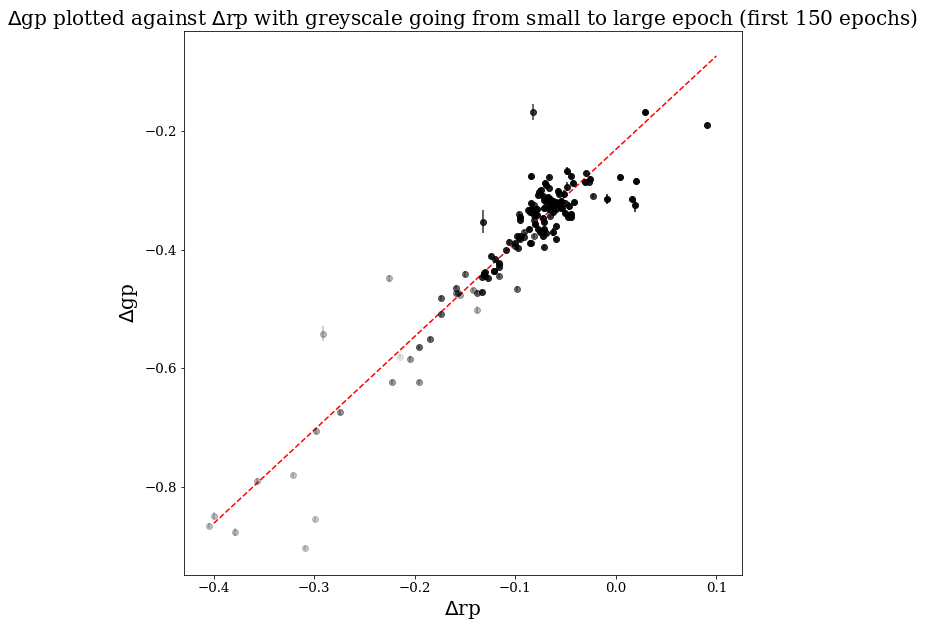

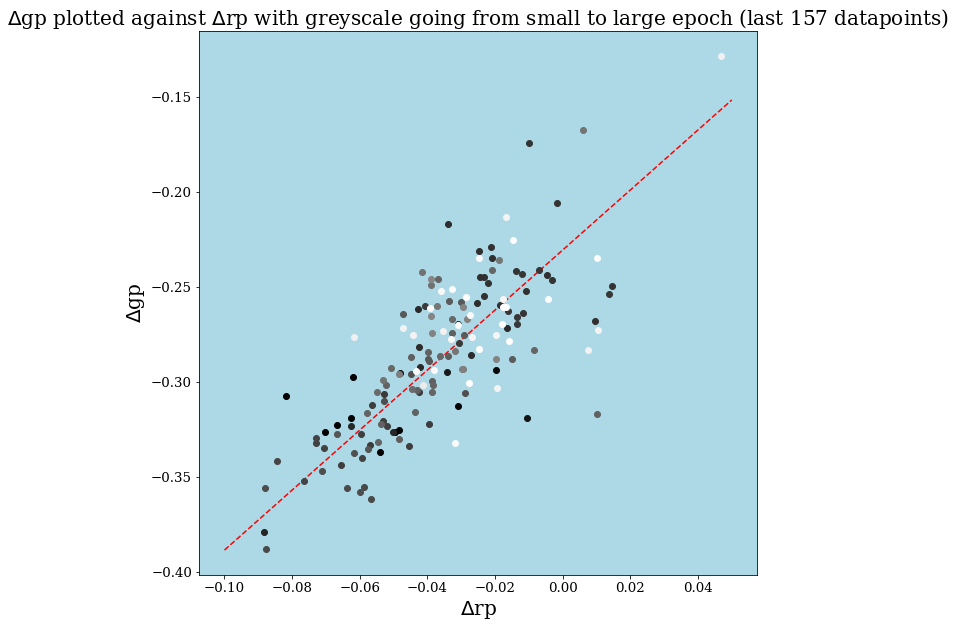

In [59]:


# split the epochs in two of ~150 datapoints
dotcolor = (epoch['gp'][m1*m2]-epoch['gp'][m1*m2][0])/(epoch['gp'][m1*m2][150]-epoch['gp'][m1*m2][0])
x = np.linspace(-0.4,0.1,100)

plt.figure(figsize=(10,10))
plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
for e in np.arange(len(epoch['gp'][m1*m2]))[:150]:
    plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
                yerr=J0600_magerr['gp'][m1*m2][e],marker='o',c='black', alpha=(dotcolor[e]*.9+0.1))
    #plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
    #            marker='o',c='black', alpha=(dotcolor[e]*.9+0.1))
plt.title("$\Delta$gp plotted against $\Delta$rp with greyscale going from small to large epoch (first 150 epochs)")
plt.xlabel("$\Delta$rp")
plt.ylabel("$\Delta$gp")
plt.show()

dotcolor = (epoch['gp'][m1*m2]-epoch['gp'][m1*m2][150])/(epoch['gp'][m1*m2][-1]-epoch['gp'][m1*m2][150])
x = np.linspace(-0.1,0.05,100)

plt.figure(figsize=(10,10))
ax=plt.axes()
#ax.set(figsize=(10,10))
ax.set(facecolor='lightblue')
plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
for e in np.arange(len(epoch['gp'][m1*m2]))[150:]:
    #plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
    #            yerr=.005,marker='o',c=str(dotcolor[e]*0.9+0.1), cmap=cmap)
    plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
                 fmt='--o',c=str((dotcolor)[e]))
    #plt.errorbar((J0600_gaiamag['rp']-J0600_rp_interp)[e],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[e],
    #            marker='o',c='black', alpha=(dotcolor[e]))
#plt.plot((J0600_gaiamag['rp']-J0600_rp_interp)[150:],(J0600_gaiamag['gp']-J0600_mag['gp'][m1*m2])[150:])
plt.title("$\Delta$gp plotted against $\Delta$rp with greyscale going from small to large epoch (last "+str(len(epoch['gp'][m1*m2])-150)+" datapoints)")
plt.xlabel("$\Delta$rp")
plt.ylabel("$\Delta$gp")
plt.show()

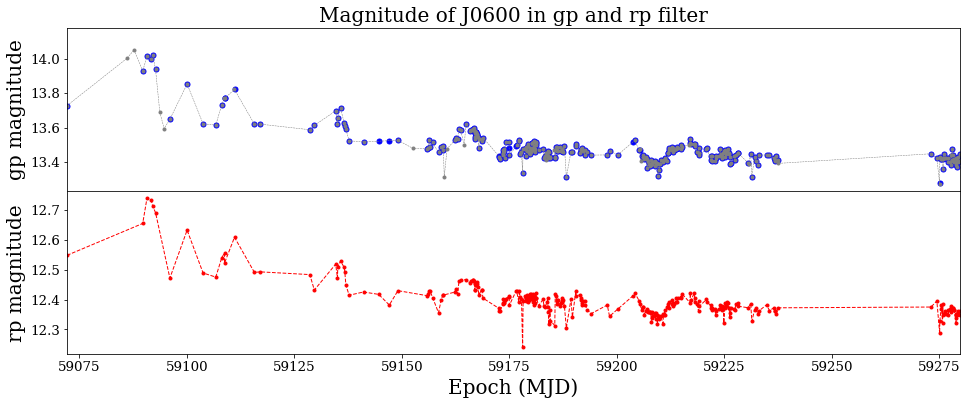

In [60]:
# Now we use gp mapped on rp epoch's

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
fig.set_figheight(6)
fig.set_figwidth(16)
axs[0].set_title('Magnitude of J0600 in gp and rp filter')
axs[0].plot(epoch['rp'][m3*m4], J0600_gp_interp, marker='o',linestyle='',c='b',markersize=5)
axs[0].plot(epoch['gp'],J0600_mag['gp'],marker='.',linestyle='dashed',linewidth=0.5,c='grey',markersize=6)
axs[0].set_ylabel("gp magnitude")

axs[1].plot(epoch['rp'],J0600_mag['rp'],marker='.',linestyle='dashed',linewidth=1,c='r',markersize=6)
axs[1].set_ylabel("rp magnitude")
axs[1].set_xlabel("Epoch (MJD)")
axs[1].set_xlim(np.min(epoch['gp'][m1*m2]),np.max(epoch['gp'][m1*m2]))

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


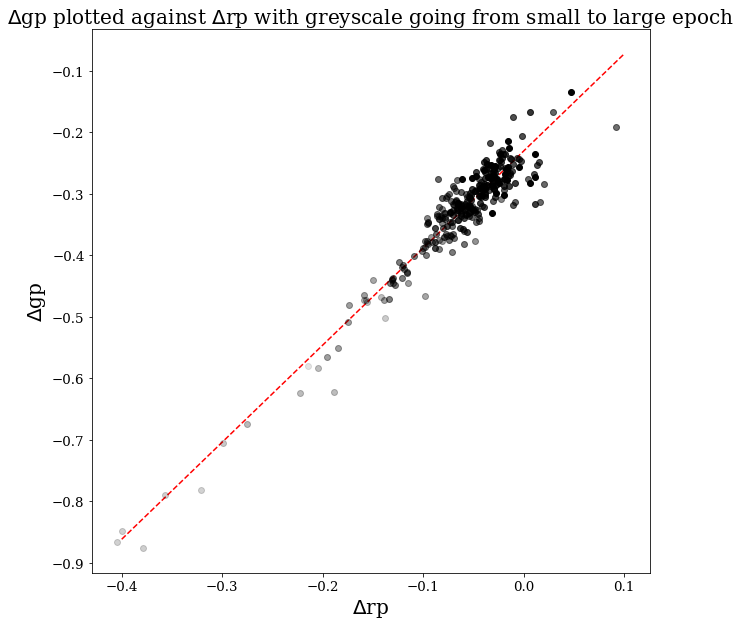

In [61]:
popt2, pcov2 = optimize.curve_fit(linear2, J0600_gaiamag['rp']-J0600_mag['rp'][m3*m4],\
                                (J0600_gaiamag['gp']-J0600_gp_interp))

dotcolor = (epoch['rp'][m3*m4]-epoch['rp'][m3*m4][0])/(epoch['rp'][m3*m4][-1]-epoch['rp'][m3*m4][0])
plt.figure(figsize=(10,10))
x = np.linspace(-0.4,0.1,100)
plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
for e in np.arange(len(epoch['rp'][m3*m4])):
    #plt.errorbar((J0600_gaiamag['rp']-J0600_mag['rp'][m3*m4])[e],(J0600_gaiamag['gp']-J0600_gp_interp)[e],
    #            xerr=J0600_magerr['rp'][m3*m4][e],fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
    plt.errorbar((J0600_gaiamag['rp']-J0600_mag['rp'][m3*m4])[e],(J0600_gaiamag['gp']-J0600_gp_interp)[e],
                fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
plt.title("$\Delta$gp plotted against $\Delta$rp with greyscale going from small to large epoch")
plt.xlabel("$\Delta$rp")
plt.ylabel("$\Delta$gp")
plt.show()

In [62]:
#split for first half and last half
print (np.sum(m3*m4))

dotcolor = (epoch['rp'][m3*m4]-epoch['rp'][m3*m4][0])/(epoch['rp'][m3*m4][150]-epoch['rp'][m3*m4][0])
plt.figure(figsize=(10,10))
x = np.linspace(-0.4,0.1,100)
plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
for e in np.arange(len(epoch['rp'][m3*m4]))[:150]:¶
    #plt.errorbar((J0600_gaiamag['rp']-J0600_mag['rp'][m3*m4])[e],(J0600_gaiamag['gp']-J0600_gp_interp)[e],
    #            xerr=J0600_magerr['rp'][m3*m4][e],fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)#,linewidth=.2)
    plt.errorbar((J0600_gaiamag['rp']-J0600_mag['rp'][m3*m4])[e],(J0600_gaiamag['gp']-J0600_gp_interp)[e],
                fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
plt.title("$\Delta$gp plotted against $\Delta$rp with greyscale going from small to large epoch (first 150 epochs)")
plt.xlabel("$\Delta$rp")
plt.ylabel("$\Delta$gp")
plt.show()

dotcolor = (epoch['rp'][m3*m4]-epoch['rp'][m3*m4][150])/(epoch['rp'][m3*m4][-1]-epoch['rp'][m3*m4][150])
plt.figure(figsize=(10,10))
x = np.linspace(-0.1,0.1,100)
plt.plot(x,linear2(x,*popt),c='r',linestyle='dashed')
for e in np.arange(len(epoch['rp'][m3*m4]))[150:]:
    #plt.errorbar((J0600_gaiamag['rp']-J0600_mag['rp'][m3*m4])[e],(J0600_gaiamag['gp']-J0600_gp_interp)[e],
    #            xerr=J0600_magerr['rp'][m3*m4][e],fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
    plt.errorbar((J0600_gaiamag['rp']-J0600_mag['rp'][m3*m4])[e],(J0600_gaiamag['gp']-J0600_gp_interp)[e],
                fmt='o',c='black', alpha=dotcolor[e]*0.9+0.1)
plt.title("$\Delta$gp plotted against $\Delta$rp with greyscale going from small to large epoch (last "+str(len(epoch['rp'][m3*m4])-150)+" datapoints)")
plt.xlabel("$\Delta$rp")
plt.ylabel("$\Delta$gp")
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-62-25a2bacb5a33>, line 8)

# Using linear algebra to solve for the fitting parameters

In [ ]:
linalg_fit = {}
for f in filt2:
    tmp = []
    for e in range(len(epoch[f])):
        nonNaN = np.isnan(mx[f][e]) == False
        N = N_stars - np.sum(nonNaN == False)
        
        A = np.zeros((N,N))
        for i in range(N):
            A[i] = (gaia_c[f]**i)[nonNaN]
        
        B = (gaia_mag[f]-mx[f][e])[nonNaN]
        
        X = np.linalg.inv(A).dot(B)
        tmp.append(np.array(X))
    linalg_fit[f] = np.array(tmp)

for f in filt2:
    print (np.shape(linalg_fit[f]))

In [ ]:
testmag = {}
for f in filt2:
    tmp1 = []
    for e in range(len(epoch[f])):
        nonNaN = np.isnan(mx[f][e]) == False
        m = 0
        m += mx[f][e]
        for i in range(19):
            m += (gaia_c[f]**i) * (linalg_fit[f][e][i])
        tmp1.append(m)
    testmag[f] = np.array(tmp1)

for f in filt2:
    print (np.shape(testmag[f]))


In [ ]:
for f in filt2:
    for s in range(N_stars):
        plt.plot(epoch[f], testmag[f][:,s])
    #plt.yscale('log')
    plt.show()

# Looking for millimagnitude variations (failed, maybe try ringaling?)

f = 'gp'
s = 7
print (np.where(epoch[f]>58932))
print (epoch[f][427])
N = 741

sick = (mag[f][:N,s]/mmag[f][s])


#filter some very wide values
leuk_nr = {'gp':1}


i = np.argsort(np.abs(sick-1))
tmp = []
for e in range(N):
    tmp.append(sick[e] not in sick[i][-leuk_nr[f]:])

leuk = np.array(tmp)
print (np.sum(leuk==False))

# Looking for millimagnitude variations:
plt.figure(figsize=(16,6))
plt.plot([0,1e6],[mmag[f][s],mmag[f][s]],c='r',linestyle='dashed')
plt.errorbar(epoch[f][:N],mag[f][:N,s], fmt='--.',linewidth=0.2,c='b')
plt.title(f+" magnitude of star "+str(s))
plt.xlabel("Epoch [MJD]")
plt.ylabel("Magnitude")
#plt.xlim(58850,58860)
plt.xlim(np.min(epoch[f]),epoch[f][N-1])#,58932)
#plt.ylim(ymin=0.998,ymax=1.002)
#plt.yscale('log')
plt.show()

def sine(x,A, x0, T,B):
    return A*np.sin((x+x0)*2*np.pi/T) + B

popt, pcov = optimize.curve_fit(sine, epoch[f][:N],mag[f][:N,s],p0=[0.01,0,10,mmag[f][s]])
print (popt)

plt.figure(figsize=(16,6))
#plt.plot([0,1e6],[mmag[f][s],mmag[f][s]],c='r',linestyle='dashed')
x = np.linspace(epoch[f][0],epoch[f][N],10000)
plt.plot(x,sine(x,*popt),c='r')
plt.errorbar(epoch[f][:N],mag[f][:N,s], fmt='.',linewidth=0.2,c='b')
plt.title(f+" magnitude of star "+str(s))
plt.xlabel("Epoch [MJD]")
plt.ylabel("Magnitude")
#plt.xlim(58840,58870)
#plt.xlim(np.min(epoch[f]),epoch[f][N-1])#,58932)
#plt.ylim(ymin=0.998,ymax=1.002)
#plt.yscale('log')
plt.show()